# Vector Quantization

This code is provided as supplementary material of the lecture Quellencodierung.

This code illustrates
* Audio example of vector quantization with optimized codebooks

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
import shutil
import scipy.signal as sp
from scipy.io import wavfile
import IPython.display as ipd
from pylab import rcParams
rcParams['axes.xmargin'] = 0

Load and display wave file

In [56]:
def audio_load(filename, sr = None):
    old_sampling_rate, x = wavfile.read(filename)
    if len(x.shape) == 2:
        x = np.squeeze(x[:,0])
    x = x/32768
    if sr is not None:
        sampling_rate = sr
        number_of_samples = round(len(x) * sampling_rate / old_sampling_rate) 
        x = sp.resample(x, number_of_samples)
    else:
        sampling_rate = old_sampling_rate
    return x, sampling_rate

In [57]:
def audio_display_waveshow(y, sr, alpha = 0.8, color = 'skyblue', linewidth = 1):
    time = np.linspace(0, len(y) / sr, num=len(y))
    #plt.plot(time, y, color=color, alpha=alpha, linewidth=1)
    #plt.xlim(time[0], time[-1])
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.fill_between(time, -np.abs(y), np.abs(y), color='skyblue')
    plt.xlabel("Time")

In [58]:
wave_filename = '../audio/33711__acclivity__excessiveexposure.wav'
#wave_filename = '../audio/E-Core - Pingouin-Banquise_45s.wav'
#wave_filename = '../audio/KIMIKO ISHIZAKA - Goldberg Variations BWV 988 - 01 - Aria_45s.wav'
x, sampling_rate = audio_load(wave_filename, sr = 22050)

<Figure size 1400x500 with 0 Axes>

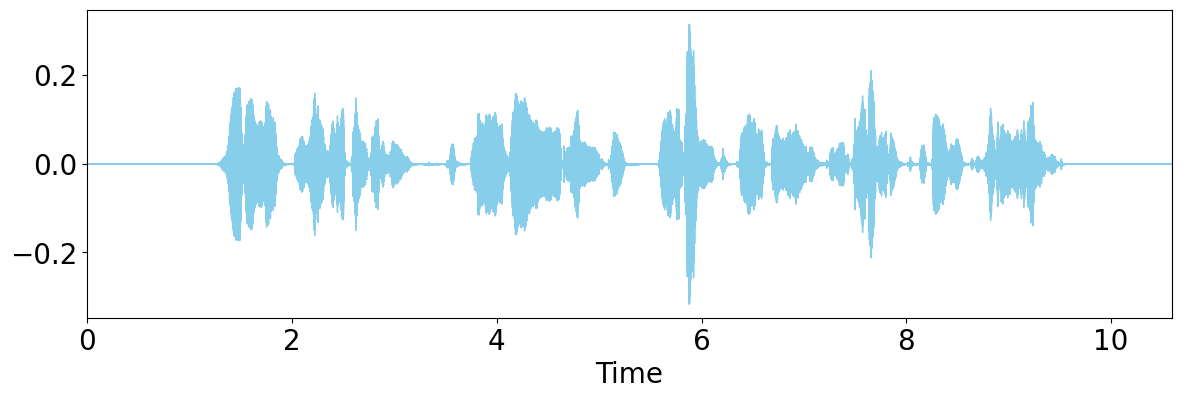

In [59]:
plt.figure(figsize=(14, 5))
audio_display_waveshow(x, sr=sampling_rate)

Play wave file

In [60]:
ipd.Audio(wave_filename) # load a local WAV file

## Uniform Quantization with Midrise Quantizer

In [61]:
w = 4

# fix x_max based on the current signal, leave some room
x_max = np.max([np.max(x), -np.min(x)])
Delta_x = x_max / (2**(w-1))


xh_uniform_midrise = np.sign(x)*Delta_x*(np.floor(np.abs(x)/Delta_x)+0.5) 

# playback quantized audio
ipd.Audio(xh_uniform_midrise, rate=sampling_rate)

(-0.37876182964719307, 0.37876182964719307)

<Figure size 1400x1500 with 0 Axes>

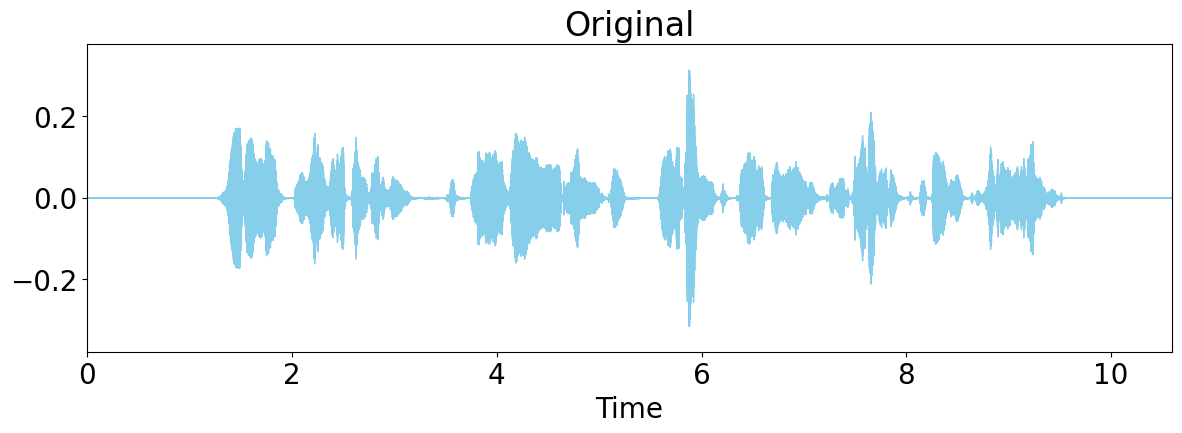

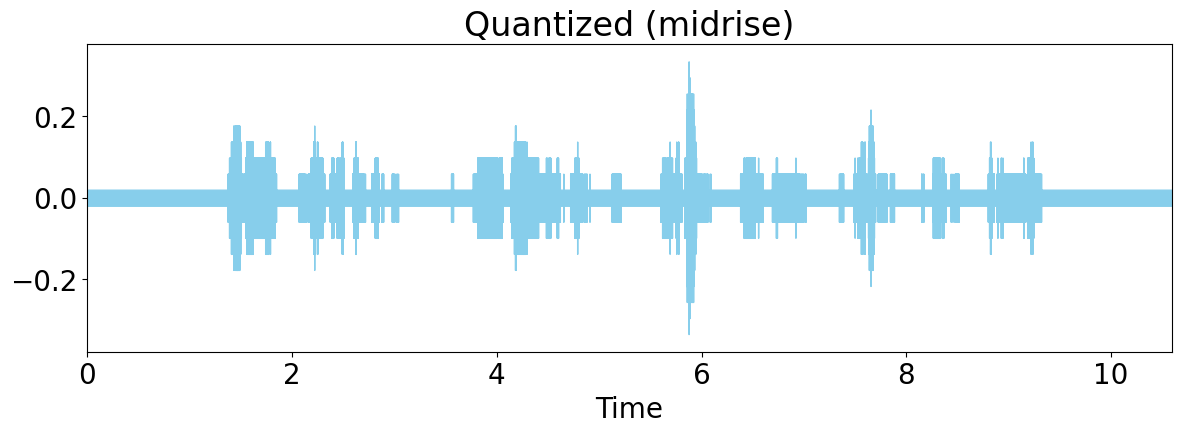

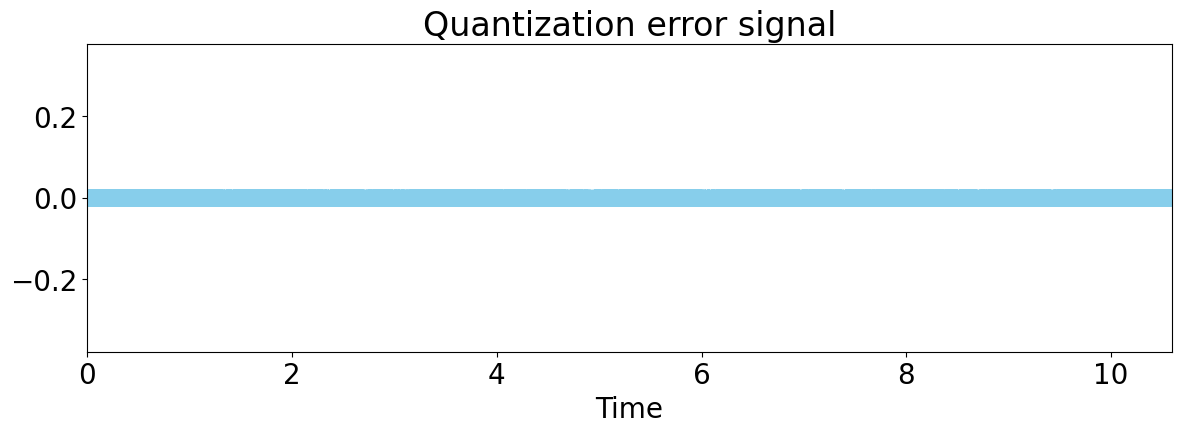

In [62]:
plt.figure(figsize=(14, 15))
#plt.subplot(3,1,1)
audio_display_waveshow(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-x_max*1.2,+x_max*1.2))
#plt.subplot(3,1,2)
audio_display_waveshow(xh_uniform_midrise, sr=sampling_rate)
plt.title('Quantized (midrise)')
plt.ylim((-x_max*1.2,+x_max*1.2))
#plt.subplot(3,1,3)
audio_display_waveshow(x-xh_uniform_midrise, sr=sampling_rate)
plt.title('Quantization error signal')
plt.ylim((-x_max*1.2,+x_max*1.2))

## Scalar Quantization with Lloyd-Max-Algorithm

In [63]:
def Lloyd_Max_Quantizer(initial_cb, x):
    #large number for inifity
    lm_inf = 10*np.max([np.max(x), -np.min(x)])

    codebook = initial_cb.copy()

    codebooks = [codebook]
    iter = 0
    while True:
        thresholds = [-lm_inf] + [0.5*(codebook[t]+codebook[t+1]) for t in range(len(codebook)-1)] + [lm_inf]

        old_cb = codebook.copy()
        for k in range(len(codebook)):
            # new codebook center
            # find those samples that are in the quantization interval (indicator function)            
            samples = x[(x >= thresholds[k]) & (x < thresholds[k+1])]
            if len(samples)==0:
                continue
            codebook[k] = sum(samples)/len(samples)
       
        iter += 1        
    
        codebooks.append(codebook.copy())
        if np.max(np.abs([codebook[i] - old_cb[i] for i in range(len(codebook))])) < 1e-5:
            break
                
    # also return all intermediate codebooks for plotting evolution
    return codebooks,codebook
    
# carry out quantization based on arbitrary codebook
def quantize_LM(codebook, x):
    #large number for inifity
    lm_inf = 10*np.max([np.max(x), -np.min(x)])

    thresholds = [-lm_inf] + [0.5*(codebook[t]+codebook[t+1]) for t in range(len(codebook)-1)] + [lm_inf]
    
    xh = np.zeros_like(x)
    
    for k in range(len(codebook)):
        # new codebook center
        # find those samples that are in the quantization interval (indicator function)
        idx = (x >= thresholds[k]) & (x < thresholds[k+1])            
        xh[idx] = codebook[k]
        
    return xh

In [64]:
# fix x_max based on the current signal, leave some room
x_max = np.max(x)
x_min = np.min(x)
# arrange codebook exactly between minimum and maximum of file

Delta_x = (x_max-x_min) / (2**w)

# generate codebook of initial midrise uniform quantizer
codebook_LM = list(reversed([-Delta_x/2 - i*Delta_x for i in range(2**(w-1))])) + [Delta_x/2 + i*Delta_x for i in range(2**(w-1))]

# construct codebook using Lloyd-Max Quantizer
codebooks,newcb = Lloyd_Max_Quantizer(codebook_LM, x)

# quantize
xh_optimal = quantize_LM(newcb, x)

# playback quantized audio
ipd.Audio(xh_optimal, rate=sampling_rate)

(-0.31236369388388857, 0.31236369388388857)

<Figure size 1400x1500 with 0 Axes>

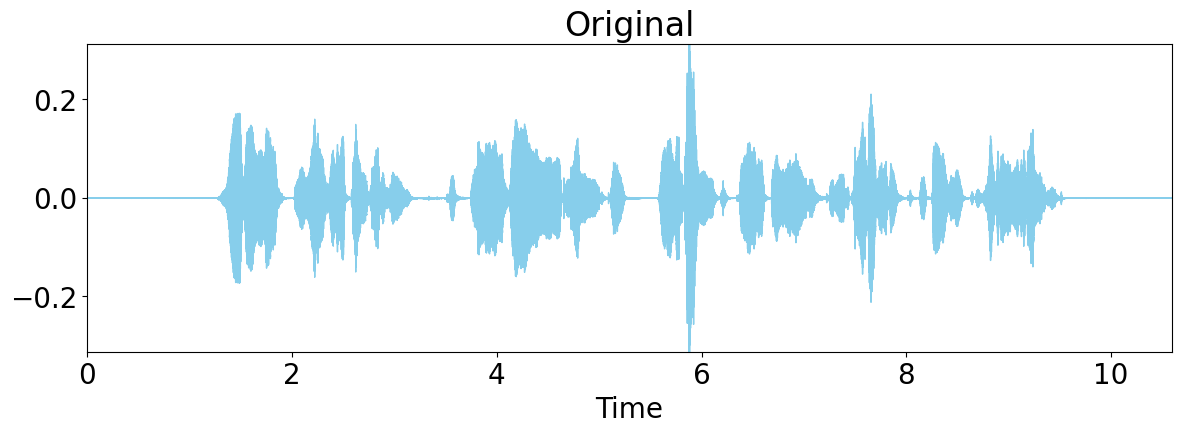

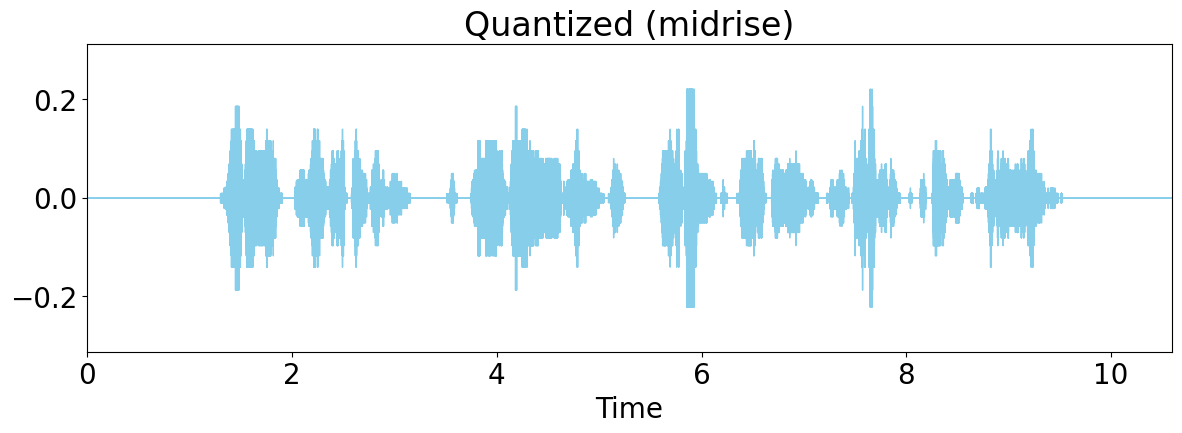

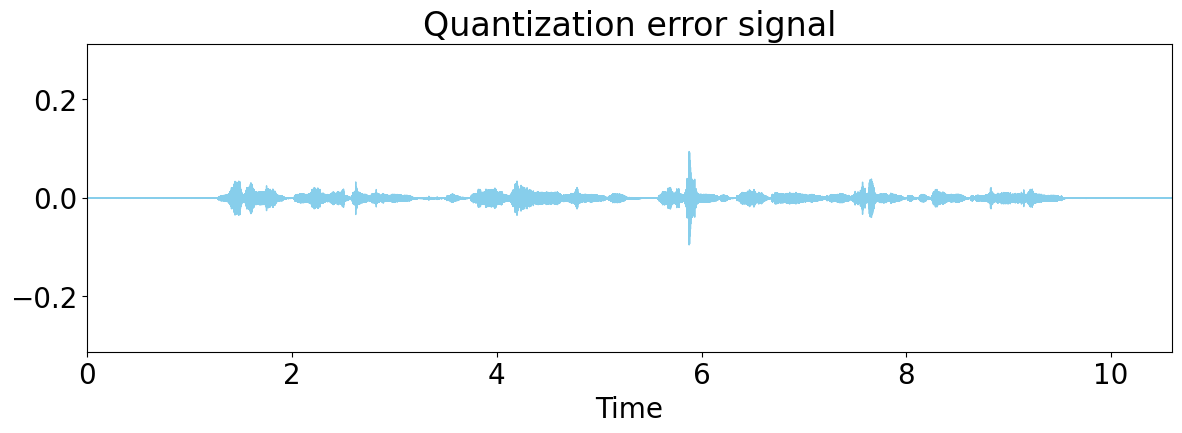

In [65]:
plt.figure(figsize=(14, 15))
#plt.subplot(3,1,1)
audio_display_waveshow(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-x_max*1.2,+x_max*1.2))
#plt.subplot(3,1,2)
audio_display_waveshow(xh_optimal, sr=sampling_rate)
plt.title('Quantized (midrise)')
plt.ylim((-x_max*1.2,+x_max*1.2))
#plt.subplot(3,1,3)
audio_display_waveshow(x-xh_optimal, sr=sampling_rate)
plt.title('Quantization error signal')
plt.ylim((-x_max*1.2,+x_max*1.2))

## Vector Quantization

In [66]:
def quantize(codebook, x):
    # compute all pairs of distances
    distances = distance.cdist(x, codebook, 'euclidean')

    # find minimum distance
    i_opt = np.argmin(distances, axis=1)
    return i_opt
    
    
# can provide initial codebook, otherwise use random one    
# for simplicity, we only employ algorithm A
def LindeBuzoGray_AlgorithmA(x,K, codebook = []):
    K_T = x.shape[0]
    L = x.shape[1]
    
    max_x = np.amax(x, axis=0)
       
    # random initial codebook
    if len(codebook) == 0:
        codebook = np.random.uniform(-max_x, max_x, (K,L))
    
    old_Dm = -1
    
    print('Generating codebook can take a while ... please wait')
    while True:
        # quantize
        iopt = quantize(codebook,x)
        xh = codebook[iopt]

        # compute average distortion
        Dm = np.mean(np.sum(np.square(x-xh),axis=1))

        if np.abs(Dm-old_Dm)/Dm < 1e-6:
            break
        old_Dm = Dm
        
        # generate new codebook by replacing entries with centroids
        for k in range(K):
            points = np.where(iopt == k)    
            if len(points[0]) > 0:
                codebook[k,:] = np.mean(x[points[0],:], axis=0)
            else:
                # if no point is assigned to the codebook entry, means it will never get changed, we replace it with a random entry
                codebook[k,:] = np.random.uniform(-max_x, max_x, (1,L))

                
    return codebook

In [67]:
# 2-dimensions
L = 2 

#code books size
K = 2**(w*L)

# generate training set
K_T = int(np.floor(len(x)/L))

x_seg = np.reshape(x[0:L*K_T],(K_T,L))
codebook = LindeBuzoGray_AlgorithmA(x_seg, K)

Generating codebook can take a while ... please wait


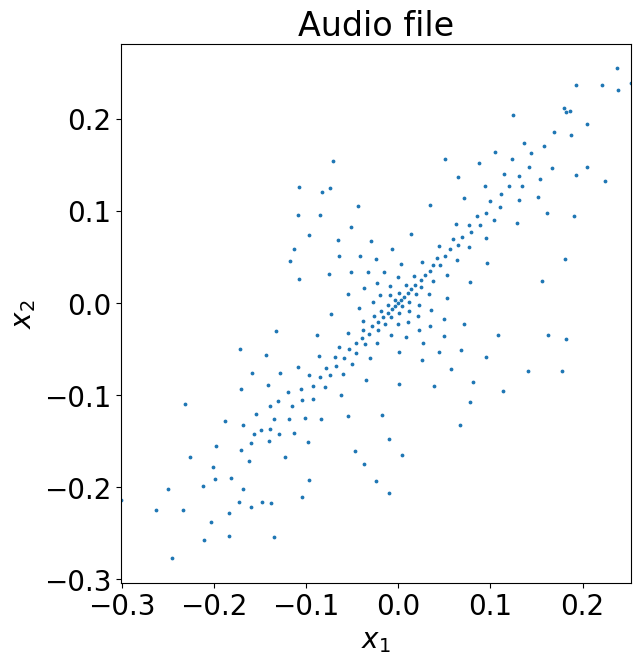

In [68]:
# plot codebook
fig = plt.figure(figsize=(7, 7))
plt.scatter(codebook[:,0], codebook[:,1], s=3)
plt.gca().set_aspect(aspect='equal')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Audio file');

In [69]:
# carry out actual quantization
i_opt = quantize(codebook, x_seg)
xh_vector = np.reshape(codebook[i_opt], L*K_T)

# playback quantized audio
ipd.Audio(xh_vector, rate=sampling_rate)

(-0.31236369388388857, 0.31236369388388857)

<Figure size 1400x1500 with 0 Axes>

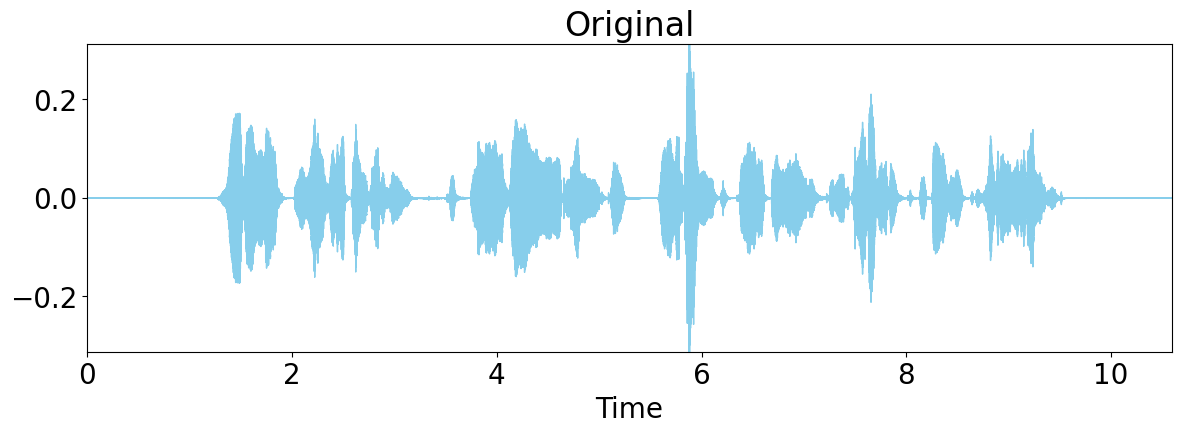

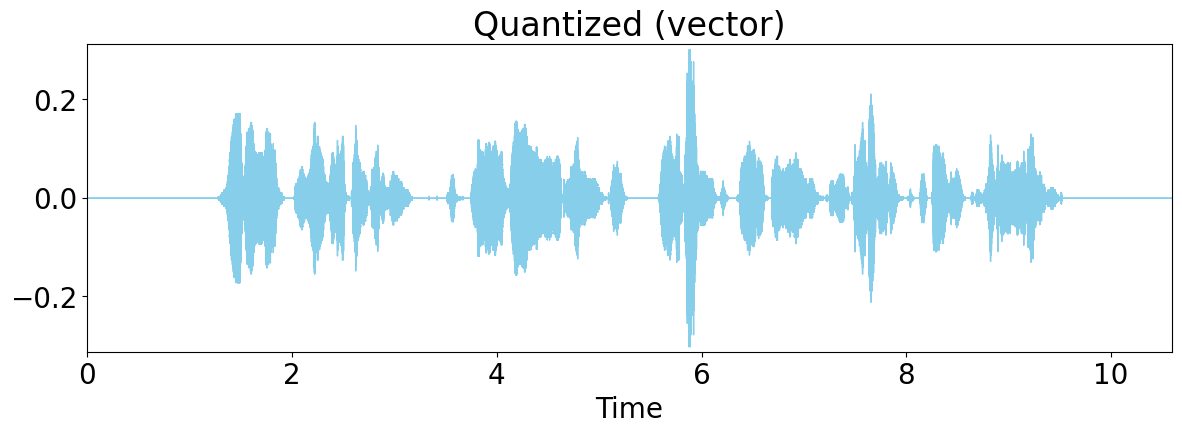

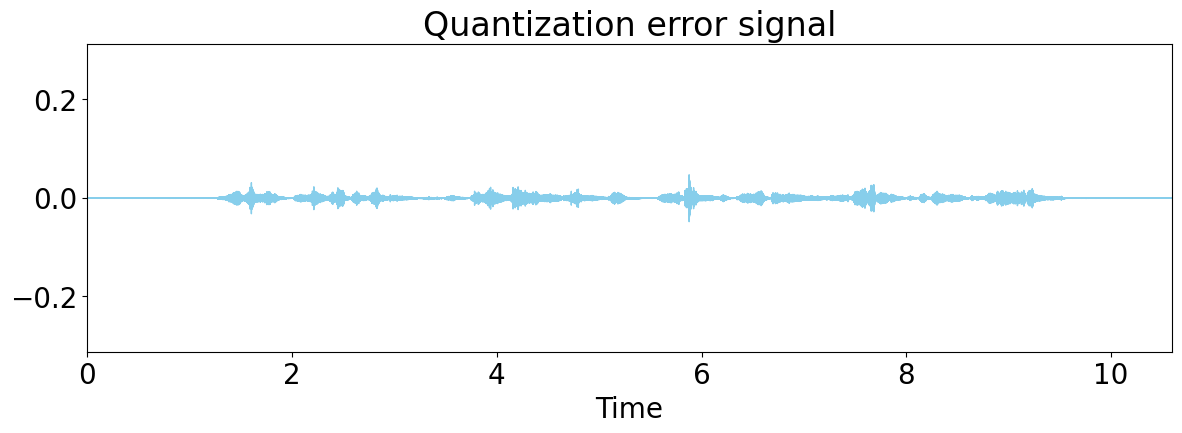

In [70]:
plt.figure(figsize=(14, 15))
#plt.subplot(3,1,1)
audio_display_waveshow(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-x_max*1.2,+x_max*1.2))
#plt.subplot(3,1,2)
audio_display_waveshow(xh_vector, sr=sampling_rate)
plt.title('Quantized (vector)')
plt.ylim((-x_max*1.2,+x_max*1.2))
#plt.subplot(3,1,3)
audio_display_waveshow(x[0:L*K_T]-xh_vector, sr=sampling_rate)
plt.title('Quantization error signal')
plt.ylim((-x_max*1.2,+x_max*1.2))

In [71]:
# Compute segmental SNR

# number of samples used for segmentation
seg_len = 256
segments = int(np.floor(len(xh_vector)/seg_len))

x_snr_seg = np.reshape(x[0:segments*seg_len],(segments,seg_len))

xh_snr_seg = np.reshape(xh_uniform_midrise[0:segments*seg_len],(segments,seg_len))
snr_scalar_seg = 10*np.log10(np.mean(np.square(x_snr_seg),axis=1) / np.mean(np.square(xh_snr_seg - x_snr_seg),axis=1))

xh_snr_seg = np.reshape(xh_optimal[0:segments*seg_len],(segments,seg_len))
snr_optimal_seg = 10*np.log10(np.mean(np.square(x_snr_seg),axis=1) / np.mean(np.square(xh_snr_seg - x_snr_seg),axis=1))

xh_snr_seg = np.reshape(xh_vector[0:segments*seg_len],(segments,seg_len))
snr_vector_seg = 10*np.log10(np.mean(np.square(x_snr_seg),axis=1) / np.mean(np.square(xh_snr_seg - x_snr_seg),axis=1))

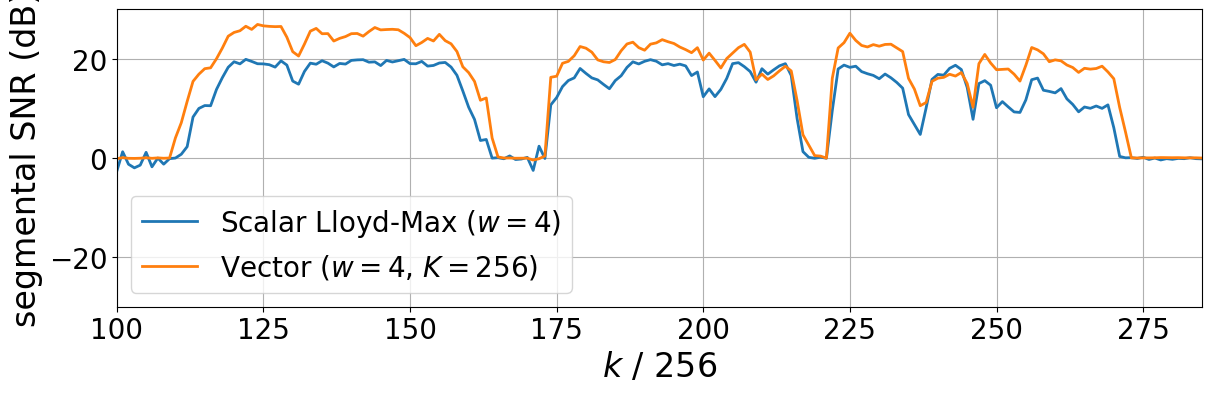

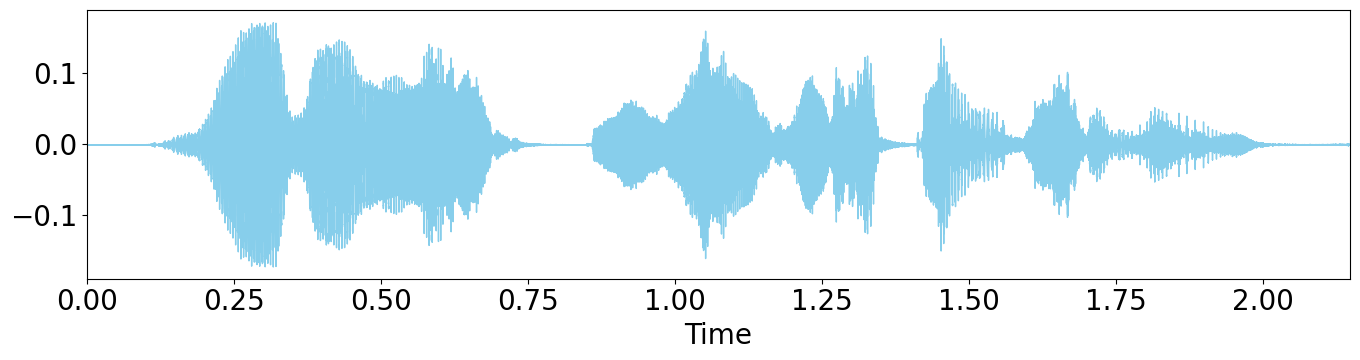

In [72]:
# plot segmental snr
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True if shutil.which('latex') else False)

plt.figure(figsize=(14, 8.5))
plt.subplot(2,1,1)
plt.plot(np.arange(segments), snr_optimal_seg, linewidth=2)
plt.plot(np.arange(segments), snr_vector_seg, linewidth=2)
plt.xlabel('$k$ / %d' % seg_len, fontsize=24)
plt.ylabel('segmental SNR (dB)', fontsize=24)
plt.ylim((-30,30))
plt.grid()

x_start = 25600 // seg_len
x_stop = 72960 // seg_len

plt.xlim((x_start,x_stop))
plt.legend(['Scalar Lloyd-Max ($w=4$)','Vector ($w=4$, $K=256$)'])

#plt.subplot(2,1,2)
audio_display_waveshow(x[(x_start*seg_len+seg_len//2):(x_stop*seg_len+seg_len//2)], sr=sampling_rate)
plt.tight_layout()

#plt.savefig('vector_segmentalSNR_w%d.pdf' % w, bbox_inches='tight')